In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import gzip
import torchaudio.transforms as T
import matplotlib
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random


In [2]:
# Configuration
base_path = Path('datasets/')
audio_path = Path('datasets/sons/audio/')
meta_path = Path('datasets/sons/meta/esc50.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paramètres
seed = 0
test_size = 0.2
max_samples = 2000
batch_size = 32
lr = 3e-4
epochs = 100
positive_ratio = 0.5  # Ratio de paires positives dans le dataset

 # Fixer toutes les seeds pour la reproductibilité
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialisation des dataloaders avec seed fixe
generator = torch.Generator()
generator.manual_seed(seed)

# Pour le plotting interactif
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
import json

replay_buffer = []
with open("replay_buffer.txt", "r") as f:
    for line in f:
        replay_buffer.append(json.loads(line))

In [4]:
replay_buffer_path = "replay_buffer.txt"
def prepare_datasets(replay_buffer_path, max_samples=None, split_ratio=0.8, seed=0):
    import json
    from torch.utils.data import Dataset, DataLoader, random_split

    buffer = []
    with open("replay_buffer.txt", "r") as f:
        for line in f:
            buffer.append(json.loads(line))
    if max_samples:
        buffer = buffer[:max_samples]

    class ReplayBufferDataset(Dataset):
        def __init__(self, buffer):
            self.buffer = buffer
        def __len__(self):
            return len(self.buffer)
        def __getitem__(self, idx):
            item = self.buffer[idx]
            img = torch.tensor(item['partial_obs'], dtype=torch.float32)
            audio = torch.tensor(item['sound'], dtype=torch.float32)
            label = torch.tensor(item['label'], dtype=torch.float32)

            #toujours [C, H, W]
            if img.ndim == 2:
                img = img.unsqueeze(0)  # [1, H, W]
            elif img.ndim == 3:
                if img.shape[-1] == 1 or img.shape[-1] == 3:
                    img = img.permute(2, 0, 1)  # [C, H, W]
                elif img.shape[0] == 1 or img.shape[0] == 3:
                    pass  # déjà [C, H, W]
                else:
                    raise ValueError(f"Image shape inattendue: {img.shape}")
            elif img.ndim == 4:
                # [B, H, W, C] ou [B, C, H, W] -> on prend le premier batch
                if img.shape[-1] == 1 or img.shape[-1] == 3:
                    img = img[0].permute(2, 0, 1)  # [C, H, W]
                elif img.shape[1] == 1 or img.shape[1] == 3:
                    img = img[0]  # déjà [C, H, W]
                else:
                    raise ValueError(f"Image shape inattendue: {img.shape}")
            elif img.ndim == 5:
                img = img[0]
                if img.shape[-1] == 1 or img.shape[-1] == 3:
                    img = img.permute(2, 0, 1)
            else:
                raise ValueError(f"Image shape inattendue: {img.shape}")

            # Si RGB, convertit en grayscale
            if img.shape[0] == 3:
                img = img.mean(dim=0, keepdim=True)  # [1, H, W]

            # Pour l'audio
            if audio.ndim == 2:
                audio = audio.unsqueeze(0)  # [1, F, T]
            elif audio.ndim == 3 and audio.shape[0] != 1:
                audio = audio.unsqueeze(0)
            
            if label.numel() > 1:
                label = label.view(-1)[0]  # Prend le premier élément si plusieurs
            else:
                label = label.squeeze()
    
            return img, audio, label

    dataset = ReplayBufferDataset(buffer)

    # Split train/test
    train_len = int(len(dataset) * split_ratio)
    test_len = len(dataset) - train_len
    train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(seed))

    train_visual = None
    test_visual = None
    audio_files = None
    audio_categories = None

    return train_dataset, test_dataset, train_visual, test_visual, audio_files, audio_categories

In [6]:
# Préparation des datasets
train_dataset, test_dataset, train_visual, test_visual, audio_files, audio_categories = prepare_datasets("replay_buffer.txt")

In [7]:
# sous-échantillonnage du dataset
def subsample_dataset(dataset, sample_ratio=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_samples = int(len(dataset) * sample_ratio)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    return Subset(dataset, indices)

# Création des sous-ensembles
train_subset = subsample_dataset(train_dataset, sample_ratio=0.7, seed=seed)
test_subset = subsample_dataset(test_dataset, sample_ratio=0.3, seed=seed)


In [8]:
# sous-échantillonnage du dataset
def subsample_dataset(dataset, sample_ratio=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_samples = int(len(dataset) * sample_ratio)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    return Subset(dataset, indices)

# Création des sous-ensembles
train_subset = subsample_dataset(train_dataset, sample_ratio=0.7, seed=seed)
test_subset = subsample_dataset(test_dataset, sample_ratio=0.7, seed=seed)

# Affichage des statistiques
def print_pair_stats(dataset, name):
    print(f"\nStatistiques pour {name}:")
    print(f"- Nombre total d'exemples: {len(dataset)}")

    def get_label(ds, idx):
        label = ds[idx][2]
        if isinstance(label, torch.Tensor):
            if label.numel() == 1:
                return label.item()
            else:
                return label.view(-1)[0].item()
        return float(label)

    if isinstance(dataset, Subset):
        labels = [get_label(dataset.dataset, i) for i in dataset.indices]
    else:
        labels = [get_label(dataset, i) for i in range(len(dataset))]

    pos = sum(labels)
    neg = len(labels) - pos

    print(f"- Paires positives: {pos} ({pos/len(dataset)*100:.1f}%)")
    print(f"- Paires négatives: {neg} ({neg/len(dataset)*100:.1f}%)")

print_pair_stats(train_subset, "Train Subset")
print_pair_stats(test_subset, "Test Subset")



Statistiques pour Train Subset:
- Nombre total d'exemples: 1959
- Paires positives: 981.0 (50.1%)
- Paires négatives: 978.0 (49.9%)

Statistiques pour Test Subset:
- Nombre total d'exemples: 489
- Paires positives: 236.0 (48.3%)
- Paires négatives: 253.0 (51.7%)


In [9]:
def compute_intrinsic_reward(model_output):
    #log_output = -torch.log(model_output + 1e-8)
    log_output = -torch.log(model_output)
    
    #récompense moyenne pour tout le batch
    reward = log_output.mean()
    
    return reward

In [10]:
def plot_metrics(metrics, current_epoch):
    plt.figure(figsize=(18, 12))
    
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.title('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['test_acc'], label='Test Accuracy')
    plt.title('Accuracy (%)')
    plt.legend()
    
    # Reward - Not Align
    plt.subplot(2, 2, 3)
    plt.plot(metrics['intrinsic_reward_not_align'], 'r-', label='Reward for not align')
    plt.title('Reward Not Align')
    plt.legend()

    # Reward - Align
    plt.subplot(2, 2, 4)
    plt.plot(metrics['intrinsic_reward_align'], 'g-', label='Reward for align')
    plt.title('Reward Align')
    plt.legend()
    
    plt.suptitle(f"Epoch {current_epoch+1}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [11]:
class AudioImageVerificationModel(nn.Module):
    def __init__(self, image_shape=(1, 7, 7), sound_shape=(128, 130)):
        super().__init__()

        C, H, W = image_shape
        self.feat_extract = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid(),
        )

        self.sound_mlp = nn.Sequential(
            nn.Linear(sound_shape[0]*sound_shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(32 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.binary_classifier = nn.Sequential(
            nn.Linear(512, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, visual_input, audio_input):
        x_image = self.feat_extract(visual_input)
        x_image = x_image.view(x_image.size(0), -1)  # flatten [B, 32]

        x_sound = audio_input.view(audio_input.size(0), -1)  # flatten
        x_sound = self.sound_mlp(x_sound)  # [B, 64]

        x = torch.cat([x_image, x_sound], dim=1)  # [B, 96]
        x = self.fc(x)  # [B, 512]
        out = self.binary_classifier(x)  # [B, 1]
        return out.squeeze(-1)

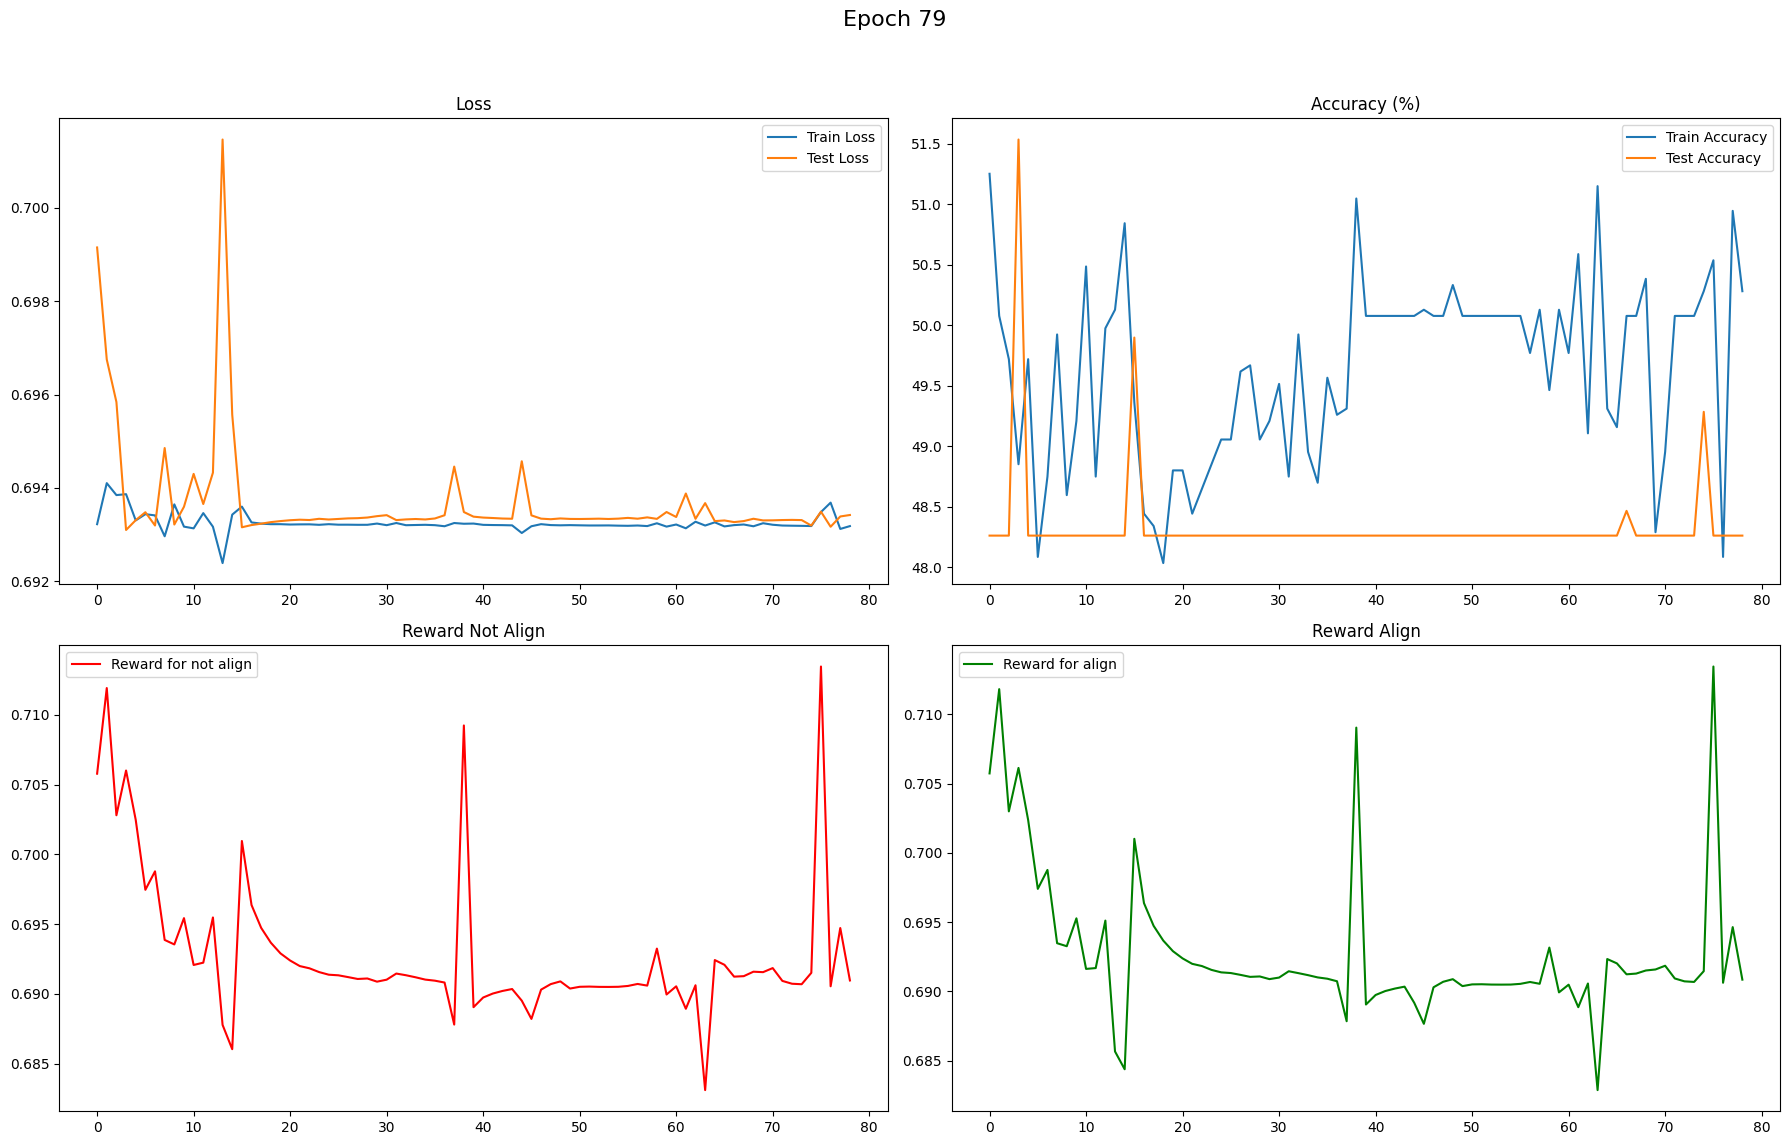


Epoch 79/100:
Train Loss: 0.6932 | Test Loss: 0.6934
Train Acc: 50.28% | Test Acc: 48.26%
Intrinsic Reward align: 0.691
Intrinsic Reward not align: 0.691


In [ ]:

def train_and_evaluate_a():
    # Configuration
    batch_size = 32
    lr = 3e-4
    epochs = 100
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed = 20
    
    # Initialisation des seeds pour reproductibilité
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # DataLoaders avec générateur reproductible
    generator = torch.Generator()
    generator.manual_seed(seed)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, 
                            shuffle=False, generator=generator)
    test_loader = DataLoader(test_subset, batch_size=batch_size,
                             shuffle=False, generator=generator)

    # Modèle et optimisation
    #model = AudioImageVerificationModel().to(device)
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    model = AudioImageVerificationModel(image_shape=(1, 7, 7), sound_shape=(32, 600)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


    criterion = nn.BCELoss()

    # Suivi des métriques simplifié
    metrics = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'outputs_align': [],
        'outputs_not_align': [],
        'intrinsic_reward_align': [],
        'intrinsic_reward_not_align': [],
        'outputs': [],
        'len_train_loader': []
    }

    for epoch in range(epochs):
        # Seed d'epoch
        epoch_seed = seed + epoch
        torch.manual_seed(epoch_seed)
        np.random.seed(epoch_seed)

        # Entraînement
        model.train()
        epoch_train_loss = 0
        epoch_train_correct = 0
        epoch_reward_align = 0
        epoch_reward_not_align = 0

        for batch_idx, (images, spectrograms, labels) in enumerate(train_loader):
            torch.manual_seed(epoch_seed + batch_idx)

            images, spectrograms = images.to(device), spectrograms.to(device)
            labels = labels.to(device)
            labels = labels.view(-1)

            #print("spectrograms.shape:", spectrograms.shape) 
            #print("labels.shape:", labels.shape)
            #print("images.shape:", images.shape) 

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, spectrograms)
            loss = criterion(outputs, labels)

            bool_align = labels == 1
            output_align = outputs[bool_align]

            bool_not_align = labels == 0
            output_not_align = outputs[bool_not_align]

            # Reward
            reward_align = compute_intrinsic_reward(output_align)
            reward_not_align = compute_intrinsic_reward(output_not_align)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Métriques
            epoch_train_loss += loss.item()
            epoch_reward_align += reward_align.item() 
            epoch_reward_not_align += reward_not_align.item() 
            preds = (outputs > 0.5).float()
            epoch_train_correct += (preds == labels).sum().item()

            metrics['outputs_align'].append(output_align)
            metrics['outputs_not_align'].append(output_not_align)
        
        # Validation
        torch.manual_seed(seed)
        model.eval()
        test_loss, test_correct = 0, 0
        test_outputs = []
        with torch.no_grad():
            for images, spectrograms, labels in test_loader:
                images, spectrograms = images.to(device), spectrograms.to(device)
                labels = labels.to(device)
                
                outputs = model(images, spectrograms)
                test_loss += criterion(outputs, labels).item()
                test_correct += ((outputs > 0.5).float() == labels).sum().item()
                test_outputs.extend(outputs.cpu().numpy())

        # Enregistrement métriques
        metrics['train_loss'].append(epoch_train_loss / len(train_loader))
        metrics['test_loss'].append(test_loss / len(test_loader))
        metrics['train_acc'].append(100 * epoch_train_correct / len(train_subset))
        metrics['test_acc'].append(100 * test_correct / len(test_subset))
        metrics['outputs'].append(outputs)
        metrics['len_train_loader'].append(len(train_loader))
        metrics['intrinsic_reward_align'].append(epoch_reward_align / len(train_loader))
        metrics['intrinsic_reward_not_align'].append(epoch_reward_not_align / len(train_loader))


        # Affichage
        if is_ipython:            
            display.clear_output(wait=True)
            plot_metrics(metrics, epoch)

        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {metrics['train_loss'][-1]:.4f} | Test Loss: {metrics['test_loss'][-1]:.4f}")
        print(f"Train Acc: {metrics['train_acc'][-1]:.2f}% | Test Acc: {metrics['test_acc'][-1]:.2f}%")
        print(f"Intrinsic Reward align: {metrics['intrinsic_reward_align'][-1]:.3f}")
        print(f"Intrinsic Reward not align: {metrics['intrinsic_reward_not_align'][-1]:.3f}")
        
    return model, metrics

model_a, metrics_a = train_and_evaluate_a()

In [ ]:
intrinsic_reward_align = metrics_a['intrinsic_reward_align']

intrinsic_reward_not_align = metrics_a['intrinsic_reward_not_align']

rewards = pd.DataFrame({
    'intrinsic_reward_align': intrinsic_reward_align,
    'intrinsic_reward_not_align': intrinsic_reward_not_align
})

print(rewards)


    intrinsic_reward_align  intrinsic_reward_not_align
0                 0.712981                    0.712954
1                 0.688279                    0.688664
2                 0.688586                    0.688720
3                 0.690691                    0.691135
4                 0.678808                    0.680704
..                     ...                         ...
95                0.260511                    5.050242
96                0.252664                    4.725874
97                0.253658                    4.954142
98                0.286721                    3.836008
99                0.281960                    3.726701

[100 rows x 2 columns]
